In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import tensorflow as tf

np.random.seed(13)
tf.random.set_seed(13)

from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from wordcloud import WordCloud
from xml.sax import ContentHandler, parse

from nltk import word_tokenize
import nltk

#nltk.download('punkt')

stemmer = SnowballStemmer('english', ignore_stopwords=True)
stop = set(stopwords.words('english'))

%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27)})

2023-05-19 11:50:11.605601: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Class that hadles excel files

In [2]:
%%time

class ExcelHandler(ContentHandler):
    def __init__(self):
        self.chars = [  ]
        self.cells = [  ]
        self.rows = [  ]
        self.tables = [  ]
    def characters(self, content):
        self.chars.append(content)
    def startElement(self, name, atts):
        if name=="Cell":
            self.chars = [  ]
        elif name=="Row":
            self.cells=[  ]
        elif name=="Table":
            self.rows = [  ]
    def endElement(self, name):
        if name=="Cell":
            self.cells.append(''.join(self.chars))
        elif name=="Row":
            self.rows.append(self.cells)
        elif name=="Table":
            self.tables.append(self.rows)



CPU times: user 28 µs, sys: 2 µs, total: 30 µs
Wall time: 34.1 µs


In [3]:
excelHandler = ExcelHandler()
parse('data/features.xls', excelHandler)
features = pd.DataFrame(excelHandler.tables[0][1:], columns=excelHandler.tables[0][0])

Parse Excel file and create dataframe


In [4]:
y = np.where(features['Label'] == 'objective', 0, 1)

Create labels: objective = 0, subjective = 1

In [5]:
texts = []
normalized_texts = []

for i in range(1, 1001):
    if i // 10 == 0:
        num = '000' + str(i)
    elif i // 100 == 0:
        num = '00' + str(i)
    elif i // 1000 == 0:
        num = '0' + str(i)
    else:
        num = '1000'
    
    f = open('data/raw-data/Text' + num + '.txt', 'r', encoding='latin-1')
    text = f.read()
    
    # removes any non-alphabetic characters and tokenizes 
    # the text from the Natural Language Toolkit (nltk)
    
    normalized_text = ' '.join([stemmer.stem(w) for w in word_tokenize(text) if (w.isalpha() and w not in stop)])
    texts.append(text)
    normalized_texts.append(normalized_text)

Create two strings for the preprocessed texts: one for objective and one for subjective

In [6]:
X_train, X_test, y_train, y_test = train_test_split(np.array(normalized_texts), y, random_state=13, stratify=y)

Splits the data into training and testing sets for use in a machine learning model.

# Decision Tree's

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

Create an instance of the TfidfVectorize

In [8]:
vectorizer = TfidfVectorizer()

Fit the vectorizer on the training data and transform the training data

In [9]:
X_train_vectorized = vectorizer.fit_transform(X_train)

Transform the test data

In [10]:
X_test_vectorized = vectorizer.transform(X_test)

Create an instance of the DecisionTreeClassifier

In [11]:
classifier = DecisionTreeClassifier()

Fit the model on the vectorized training data

In [12]:
classifier.fit(X_train_vectorized, y_train)

DecisionTreeClassifier()

Make predictions on the vectorized test data


In [13]:
%%time
y_pred = classifier.predict(X_test_vectorized)

CPU times: user 2.03 ms, sys: 61 µs, total: 2.09 ms
Wall time: 1.58 ms


Summary of the predictions made by the classifier

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.78      0.79       159
           1       0.64      0.68      0.66        91

    accuracy                           0.74       250
   macro avg       0.72      0.73      0.73       250
weighted avg       0.75      0.74      0.75       250



Precision, recall, and F1-score provide insights into the classifier's performance for each class individually.

    Class 0 (Objective):
        Precision: 81%
        This indicates that out of all the instances predicted as objective, 81% were correctly classified.
        Recall: 78%
        It means that out of all the actual objective instances, 78% were correctly identified by the classifier.
        F1-score: 79%
        The F1-score is the harmonic mean of precision and recall. In this case, it is 79% for class 0, which indicates a reasonable balance between precision and recall.

    Class 1 (Subjective):
        Precision: 64%
        This suggests that out of all the instances predicted as subjective, only 64% were actually subjective.
        Recall: 68%
        It means that out of all the actual subjective instances, 68% were correctly identified by the 
        classifier.
        F1-score: 66%
        The F1-score for class 1 is 66%, indicating a moderate balance between precision and recall.

Comparing the precision, recall, and F1-scores between the two classes, it is evident that the classifier performs better in identifying objective texts (class 0) compared to subjective texts (class 1). The lower performance on subjective texts might be due to the complexity and subjectivity inherent in identifying subjective language patterns.

#### Confusion matrix

In [15]:
print(confusion_matrix(y_test, y_pred))

[[124  35]
 [ 29  62]]


The confusion matrix provides a detailed breakdown of the classifier's performance in terms of true positives, true negatives, false positives, and false negatives.

    True Positives (TP): 124
    The classifier correctly classified 124 instances of class 0 (objective) as objective.

    True Negatives (TN): 62
    The classifier correctly classified 62 instances of class 1 (subjective) as subjective.

    False Positives (FP): 35
    The classifier incorrectly classified 35 instances of class 0 (objective) as subjective.

    False Negatives (FN): 29
    The classifier incorrectly classified 29 instances of class 1 (subjective) as objective.

The confusion matrix indicates that the classifier has a higher rate of misclassifying objective texts as subjective (false positives) compared to misclassifying subjective texts as objective (false negatives). This suggests a potential bias towards identifying texts as subjective.

#### Accuracy Score

In [16]:
print('accuracy is',accuracy_score(y_pred,y_test))

accuracy is 0.744


# Support Vector Machine's (SVM) 

In [17]:
from sklearn.svm import SVC

Create an instance of the SVC (Support Vector Classifier)

In [18]:
classifier = SVC()

Fit the model on the vectorized training data

In [19]:
classifier.fit(X_train_vectorized, y_train)

SVC()

Make predictions on the vectorized test data

In [20]:
%%time
y_pred = classifier.predict(X_test_vectorized)

CPU times: user 317 ms, sys: 3.92 ms, total: 321 ms
Wall time: 320 ms


In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.93      0.84       159
           1       0.81      0.51      0.62        91

    accuracy                           0.78       250
   macro avg       0.79      0.72      0.73       250
weighted avg       0.78      0.78      0.76       250



#### Print the confusion matrix

In [22]:
print(confusion_matrix(y_test, y_pred))

[[148  11]
 [ 45  46]]


#### Accuracy Score

In [23]:
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.776


# K-Nearest Neighbours

In [24]:
from sklearn.neighbors import KNeighborsClassifier

Create an instance of the KNN:

In [25]:
classifier = KNeighborsClassifier(n_neighbors=8)

Fit the model on the vectorized training data

In [26]:
classifier.fit(X_train_vectorized, y_train)

KNeighborsClassifier(n_neighbors=8)

Make predictions on the vectorized test data

In [27]:
%%time
y_pred = classifier.predict(X_test_vectorized)

CPU times: user 11 s, sys: 51 ms, total: 11.1 s
Wall time: 3.26 s


Summary of the predictions made by the classifier

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.77      0.76       159
           1       0.57      0.53      0.55        91

    accuracy                           0.68       250
   macro avg       0.66      0.65      0.65       250
weighted avg       0.68      0.68      0.68       250



#### Print the confusion matrix

In [29]:
print(confusion_matrix(y_test, y_pred))

[[123  36]
 [ 43  48]]


#### Accuracy Score

In [30]:
print('accuracy is',accuracy_score(y_pred,y_test))

accuracy is 0.684


# Visual Comparison between the previous algorithms

In [31]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import OneHotEncoder

Classifiers:

In [32]:
classifiers = [
    DecisionTreeClassifier(),
    SVC(),
    KNeighborsClassifier(n_neighbors=8),
]

Logging for Visual Comparison:

In [33]:
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train_vectorized, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    
    print('****Results****')
    train_predictions = clf.predict(X_test_vectorized)
    acc = accuracy_score(y_test, train_predictions)
    print("Accuracy: {:.4%}".format(acc))
    
    log_entry = pd.DataFrame([[name, acc*100, 11]], columns=log_cols)
    log = pd.concat([log, log_entry], ignore_index=True)
    
    print("="*30)

DecisionTreeClassifier
****Results****
Accuracy: 72.8000%
SVC
****Results****
Accuracy: 77.6000%
KNeighborsClassifier
****Results****
Accuracy: 68.4000%


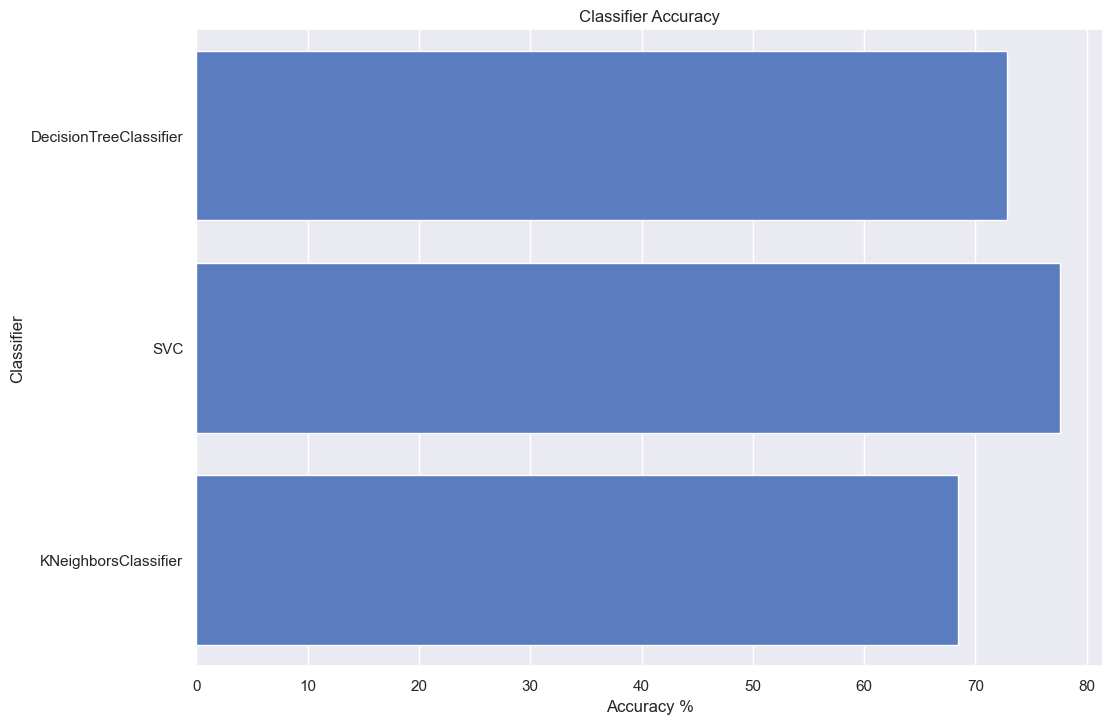

In [34]:
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
plt.show()